# Setup

In [1]:
from IPython.display import display
from lci_to_bw2 import *
from bw2data.project import ProjectManager
from bw2data.parameters import (ActivityParameter, DatabaseParameter,
                                ProjectParameter, Group)
from brightway2 import *
import bw2analyzer as bwa
import brightway2 as bw
from bw2data.parameters import *

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Directory with datasets:
ROOT_DIR = "files"

In [3]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [4]:
# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA_Repo\outputs\IMG


In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [6]:
# List of the available projects
bw.projects

Brightway2 projects manager with 5 objects:
	LCA_Glazing
	LCA_Glazing_0
	LCOPT_Setup
	default
	test
Use `projects.report()` to get a report on all projects.

In [7]:
# New project or access an existing one:
bw.projects.set_current("LCA_Glazing")

# Where the current project is:
bw.projects.dir

'C:\\Users\\souvi\\AppData\\Local\\pylca\\Brightway3\\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab'

**Abbreviation:**

- fg = flat glass
- inv = inventory
- act = activity
- norm = normalised impacts
- ia = impact assessment
- fu = functional unit
- igu = insulating glass unit

# List of Scenarios with their Parameters

Import the Excel file with the LCA scenarios (i.e. the values for the parameters to be used in BW2 and EnergyPlus):

In [8]:
LCA_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "LCA_scenarios.xlsx"))

Define a series of dataframes for each step of calculation:

In [9]:
print("LCA_scenarios, sheet names = \n {}\n".format(LCA_scenarios.sheet_names))

LCA_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16', 'Step17', 'Step18', 'Step19', 'Step20', 'Step21', 'Step22']



In [10]:
# Create dataframe for with scenarios for each step:
df_step1 = LCA_scenarios.parse('Step1').set_index('name')
df_step2 = LCA_scenarios.parse('Step2').set_index('name')
df_step3 = LCA_scenarios.parse('Step3').set_index('name')
df_step4 = LCA_scenarios.parse('Step4').set_index('name')
df_step5 = LCA_scenarios.parse('Step5').set_index('name')
df_step6 = LCA_scenarios.parse('Step6').set_index('name')
df_step7 = LCA_scenarios.parse('Step7').set_index('name')
df_step8 = LCA_scenarios.parse('Step8').set_index('name')
df_step9 = LCA_scenarios.parse('Step9').set_index('name')
df_step10 = LCA_scenarios.parse('Step10').set_index('name')
df_step11 = LCA_scenarios.parse('Step11').set_index('name')
df_step12 = LCA_scenarios.parse('Step12').set_index('name')
df_step13 = LCA_scenarios.parse('Step13').set_index('name')
df_step14 = LCA_scenarios.parse('Step14').set_index('name')
df_step15 = LCA_scenarios.parse('Step15').set_index('name')
df_step16 = LCA_scenarios.parse('Step16').set_index('name')
df_step17 = LCA_scenarios.parse('Step17').set_index('name')
df_step18 = LCA_scenarios.parse('Step18').set_index('name')
df_step19 = LCA_scenarios.parse('Step19').set_index('name')
df_step20 = LCA_scenarios.parse('Step20').set_index('name')
df_step21 = LCA_scenarios.parse('Step21').set_index('name')
df_step22 = LCA_scenarios.parse('Step22').set_index('name')

# Import of LCA Databases

In [11]:
# databases available in the current project:
bw.databases

Databases dictionary with 7 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_EoL
	exldb_igu
	exldb_spacers

## Ecoinvent and Biosphere 3

**Importing Biosphere 3:**

In [12]:
# Importing elementary flows, LCIA methods and some other data
bw.bw2setup()

Biosphere database already present!!! No setup is needed


**Importing Ecoinvent 3.7, cut-off system model:**

For more information about the system models in ecoinvent 3, and especially the cut-off one, read [this](https://www.ecoinvent.org/database/system-models-in-ecoinvent-3/cut-off-system-model/allocation-cut-off-by-classification.html).

In [13]:
# Import ecoinvent 3.7 cut-off
ei37cutdir = r"C:\Users\souvi\Documents\These\80_Calculations\06_LCA_SystemDiagrams\02_Dataset\ecoinvent 3.7_cutoff_ecoSpold02\datasets"

if 'ecoinvent 3.7 cut-off' in databases:
    print("Database has already been imported!")
else:
    ei37cut = bw.SingleOutputEcospold2Importer(
        ei37cutdir, 'ecoinvent 3.7 cut-off')
    ei37cut.apply_strategies()
    ei37cut.statistics()
    ei37cut.write_database()

Database has already been imported!


## Excel datasets

**Importing the Excel dataset relating to aluminium production:**

In [14]:
imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_Alu.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database("ecoinvent 3.7 cut-off",
                   fields=('name', 'unit', 'location', 'input'))
imp.statistics()

Extracted 2 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.25 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
2 datasets
12 exchanges
0 unlinked exchanges
  


(2, 12, 0)

Checking whether the import went as expected. Creation of an Excel sheet with process data:

In [15]:
imp.write_excel()

Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_alu.xlsx


Write the data to a database to save it:

In [16]:
imp.write_database()

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:01
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/03/2021 18:47:00
  Finished: 12/03/2021 18:47:00
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.23
Created database: exldb_alu


**Importing the Excel dataset relating to IGUs:**

In [17]:
imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_IGU.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database("ecoinvent 3.7 cut-off",
                   fields=('name', 'unit', 'location'))
imp.match_database("exldb_alu",
                   fields=('name', 'unit', 'location', 'input'))
imp.statistics()

Extracted 44 worksheets in 0.33 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
44 datasets
381 exchanges
0 unlinked exchan

(44, 381, 0)

Checking whether the import went as expected. Creation of an Excel sheet with process data:

In [18]:
imp.write_excel()

Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_igu.xlsx


Add the project-level parameters:

In [19]:
imp.write_project_parameters()

Write the data to a database to save it:

In [20]:
imp.write_database()

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/03/2021 18:47:03
  Finished: 12/03/2021 18:47:03
  Total time elapsed: 00:00:00
  CPU %: 158.20
  Memory %: 1.37
Created database: exldb_igu


**Importing the Excel dataset relating to double glazing w/ different types of spacers:**

In [21]:
imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_Spacers.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database("ecoinvent 3.7 cut-off",
                   fields=('name', 'unit', 'location'))
imp.match_database("exldb_igu",
                   fields=('name', 'unit', 'location', 'input'))
imp.statistics()

Extracted 12 worksheets in 0.10 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
12 datasets
174 exchanges
0 unlinked exchan

(12, 174, 0)

Checking whether the import went as expected. Creation of an Excel sheet with process data:

In [22]:
imp.write_excel()

Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_spacers.xlsx


Write the data to a database to save it:

In [23]:
imp.write_database()

Writing activities to SQLite3 database:
0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/03/2021 18:47:06
  Finished: 12/03/2021 18:47:06
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.34
Created database: exldb_spacers


**Importing the Excel dataset relating to curtain wall end of life phase:**

In [24]:
imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_CW_EoL.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database("ecoinvent 3.7 cut-off",
                   fields=('name', 'unit', 'location'))
imp.match_database("exldb_cw",
                   fields=('name', 'unit', 'location', 'input'))
imp.statistics()

Extracted 26 worksheets in 0.15 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.23 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
26 datasets
100 exchanges
0 unlinked exchan

(26, 100, 0)

Checking whether the import went as expected. Creation of an Excel sheet with process data:

In [25]:
imp.write_excel()

Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw_EoL.xlsx


Write the data to a database to save it:

In [26]:
imp.write_database()

Writing activities to SQLite3 database:
0% [##########################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/03/2021 18:47:08
  Finished: 12/03/2021 18:47:08
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.36
Created database: exldb_cw_EoL


**Importing the Excel dataset relating to curtain wall production and use:**

In [27]:
imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_CW.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database("ecoinvent 3.7 cut-off",
                   fields=('name', 'unit', 'location'))
imp.match_database("exldb_igu",
                   fields=('name', 'unit', 'location', 'input'))
imp.match_database("exldb_alu",
                   fields=('name', 'unit', 'location', 'input'))
imp.match_database("exldb_cw_EoL",
                   fields=('name', 'unit', 'location', 'input'))
imp.statistics()

Extracted 48 worksheets in 0.25 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.29 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


(48, 259, 0)

Checking whether the import went as expected. Creation of an Excel sheet with process data:

In [28]:
imp.write_excel()

Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw.xlsx


Write the data to a database to save it:

In [29]:
imp.write_database()

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/03/2021 18:47:11
  Finished: 12/03/2021 18:47:11
  Total time elapsed: 00:00:00
  CPU %: 140.20
  Memory %: 1.39
Created database: exldb_cw


**Checking if the imports went well:**

List databases:

In [30]:
bw.databases

Databases dictionary with 7 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_EoL
	exldb_igu
	exldb_spacers

Checking Excel database:

**Deleting a database, if needed:**

## Navigate Databases

**Navigate Databases, assigning a variable to each one:**

In [31]:
eib3db = bw.Database('biosphere3')

eicutdb = bw.Database('ecoinvent 3.7 cut-off')

exldb_alu = bw.Database('exldb_alu')
exldb_igu = bw.Database('exldb_igu')
exldb_cw = bw.Database('exldb_cw')
exldb_spacers = bw.Database('exldb_spacers')

# LCA of Glass Sheets and IGUs from Cradle to Gate

## Parameters

**Checking the total number of parameters:**

In [32]:
len(parameters)

52

Look at the parameter directly:

In [33]:
print("Project parameters:")
for p in ProjectParameter.select():
    print(p.name, ":", round(p.amount, 2))

print("------")
print("Database parameters:")
for p in DatabaseParameter.select():
    print(p.name, ":", round(p.amount, 2))

print("------")
print("Activity parameters:")
for p in ActivityParameter.select():
    if "dummy" not in p.name:
        print(p.name, ":", round(p.amount, 2))

Project parameters:
param_g_density : 2.5
param_t_lsg : 10.0
param_t_tsg : 10.0
param_n_pvb : 2.0
param_d1 : 125.0
param_t_g_ext : 8.0
param_t_g_mid_tg : 6.0
param_t_g_uncoated_int : 8.0
------
Database parameters:
param_m_sg_g : 25.0
param_m_sg_alu : 3.31
param_m_sg_low_wood : 0.09
param_m_sg_low_silicone : 0.15
param_m_sg_high_epdm : 0.55
param_m_dg_g : 45.0
param_m_dg_alu : 3.47
param_m_dg_low_wood : 0.09
param_m_dg_low_silicone : 0.15
param_m_dg_high_epdm : 0.67
param_m_tg_g : 60.0
param_m_tg_alu : 3.79
param_m_tg_epdm : 0.78
param_m_ccf_g : 70.0
param_m_ccf_alu : 13.22
param_m_ccf_epdm : 1.95
param_m_vacuum_g : 45.0
param_m_smart_g : 45.0
param_m_smart_elec : 0.94
param_m_dsf_g : 70.0
param_m_dsf_alu : 6.79
param_m_dsf_epdm : 1.22
param_d2 : 130.0
param_d3 : 50.0
param_natural_gas : 0.0
param_elec_use : 0.0
param_lifespan : 40.0
param_shdg_device : 0.0
param_thermal_curtain : 0.0
param_sg : 0.0
param_sg_coated : 0.0
param_dg : 0.0
param_dg_coated : 0.0
param_dg_coated_krypton : 0.

**We have now to tell bw to activate the exchanges and their formulas:**

First, we tell the parameter code that these exchanges have formulas:

In [34]:
for act in exldb_igu:
    parameters.add_exchanges_to_group("igu_db_parameters", act)

for act in exldb_cw:
    parameters.add_exchanges_to_group("cw_db_parameters", act)

Then we calculate the "activated" formula values:

In [35]:
ActivityParameter.recalculate_exchanges("igu_db_parameters")
ActivityParameter.recalculate_exchanges("cw_db_parameters")

**Delete the parameters:**

## Methods

List of available LCIA methods:

Define methods:

In [36]:
method_ilcd_gwp = (
    'ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

In [37]:
methods_small = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

In [38]:
methods_full = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

## Flat glass production

Define the <font color='red'> functional unit </font> per flat glass (fg) type:

In [39]:
inv_fg_unsorted = [act for act in exldb_igu
                   if 'market for flat glass' in act['name']
                   ]

inv_fg = sorted(inv_fg_unsorted,
                key=lambda k: k['name'])

inv_fg

['market for flat glass, coated' (kilogram, BE, ('building components', 'windows')),
 'market for flat glass, uncoated' (kilogram, BE, ('building components', 'windows'))]

In [40]:
names_fg_processed = ['market for laminated safety glass',
                      'market for tempered safety glass',
                      'market for smart glass'
                      ]

inv_fg_processed_unsorted = [act for act in exldb_igu
                             for n in names_fg_processed
                             if n in act['name']
                             and "glazing" not in act['name']
                             ]

inv_fg_processed = sorted(inv_fg_processed_unsorted,
                          key=lambda k: k['name'])

inv_fg_processed

['market for laminated safety glass' (square meter, BE, ('building components', 'windows')),
 'market for laminated safety glass, coated' (square meter, BE, ('building components', 'windows')),
 'market for smart glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass, coated' (square meter, BE, ('building components', 'windows'))]

In [41]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

impacts_fg = []

for act in inv_fg:
    lca = bw.LCA({act: fu_fg})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

for act in inv_fg_processed:
    lca = bw.LCA({act: fu_fg_processed})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

# impacts_fg

In [42]:
df_impacts_fg = pd.DataFrame(impacts_fg, columns=["Name", "Location", "Method",
                                                  "Score", "Unit"])

df_impacts_fg = pd.pivot_table(df_impacts_fg, index=["Name"],
                               columns=["Method", "Unit"],
                               values="Score")

In [43]:
df_impacts_fg = df_impacts_fg.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

df_impacts_fg.round(2)

Method                                    Climate Change Ecosystem Quality  \
Unit                                           kg CO2-Eq               CTU   
Name                                                                         
market for flat glass, uncoated                    27.51              7.51   
market for flat glass, coated                      29.12              9.58   
market for tempered safety glass                   29.63              7.74   
market for tempered safety glass, coated           31.27              9.85   
market for laminated safety glass                  37.33             12.78   
market for laminated safety glass, coated          38.16             13.83   
market for smart glass                            543.25           1339.11   

Method                                                                \
Unit                                      kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                   
market for flat glass, uncoated              0.00      0.23     0.61   
market for flat glass, coated                0.00      0.24     0.64   
market for tempered safety glass             0.00      0.23     0.63   
market for tempered safety glass, coated     0.00      0.25     0.66   
market for laminated safety glass            0.01      0.26     0.70   
market for laminated safety glass, coated    0.01      0.27     0.71   
market for smart glass                       0.04      2.28     7.40   

Method                                    Human Health            Resources  \
Unit                                        kg CFC-11. kg NMVOC-. megajoule   
Name                                                                          
market for flat glass, uncoated                    0.0       0.15    349.20   
market for flat glass, coated                      0.0       0.15    382.46   
market for tempered safety glass                   0.0       0.15    382.10   
market for tempered safety glass, coated           0.0       0.16    416.02   
market for laminated safety glass                  0.0       0.17    628.82   
market for laminated safety glass, coated          0.0       0.17    645.78   
market for smart glass                             0.0       2.22   8468.86   

Method                                              
Unit                                        points  
Name                                                
market for flat glass, uncoated             146.46  
market for flat glass, coated               189.15  
market for tempered safety glass            149.70  
market for tempered safety glass, coated    193.24  
market for laminated safety glass           239.95  
market for laminated safety glass, coated   261.72  
market for smart glass                     7924.06

In [44]:
df_impacts_fg = df_impacts_fg.reset_index()
df_impacts_fg['Name'] = (df_impacts_fg['Name']
                         .str.replace('market for ', ''))

df_impacts_fg = df_impacts_fg.set_index('Name')

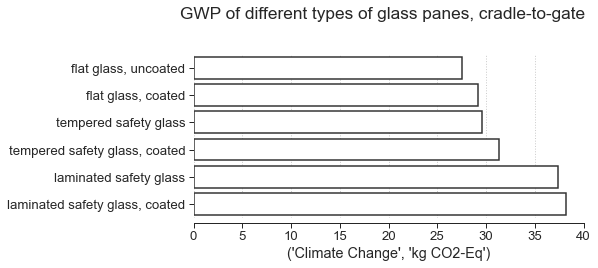

In [45]:
fig, ax = plt.subplots(figsize=(7, 3))

df_impacts_wo_smartg = df_impacts_fg.drop("smart glass", axis=0)

sns.barplot(data=df_impacts_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_wo_smartg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [46]:
df_norm_impacts_wo_smartg = (
    df_impacts_wo_smartg / df_impacts_wo_smartg.max()
)
df_norm_impacts_wo_smartg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.72              0.54    0.47   
flat glass, coated                       0.76              0.69    0.59   
tempered safety glass                    0.78              0.56    0.49   
tempered safety glass, coated            0.82              0.71    0.61   
laminated safety glass                   0.98              0.92    0.94   
laminated safety glass, coated           1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.84     0.86         0.49       0.84   
flat glass, coated                  0.89     0.90         0.52       0.88   
tempered safety glass               0.86     0.88         0.54       0.86   
tempered safety glass, coated       0.91     0.93         0.57       0.90   
laminated safety glass              0.97     0.98         0.99       0.98   
laminated safety glass, coated      1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.54   0.56  
flat glass, coated                  0.59   0.72  
tempered safety glass               0.59   0.57  
tempered safety glass, coated       0.64   0.74  
laminated safety glass              0.97   0.92  
laminated safety glass, coated      1.00   1.00

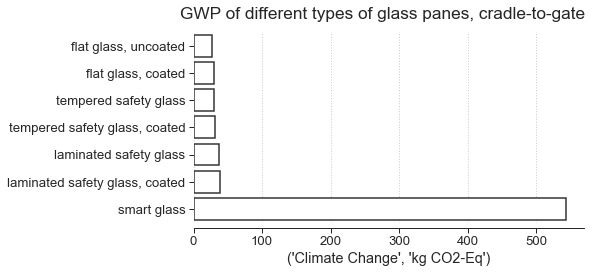

In [47]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sns.barplot(data=df_impacts_fg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_fg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [48]:
df_norm_impacts_fg = df_impacts_fg / df_impacts_fg.max()
df_norm_impacts_fg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.05              0.01    0.06   
flat glass, coated                       0.05              0.01    0.08   
tempered safety glass                    0.05              0.01    0.06   
tempered safety glass, coated            0.06              0.01    0.08   
laminated safety glass                   0.07              0.01    0.12   
laminated safety glass, coated           0.07              0.01    0.13   
smart glass                              1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.10     0.08         0.02       0.07   
flat glass, coated                  0.11     0.09         0.02       0.07   
tempered safety glass               0.10     0.09         0.02       0.07   
tempered safety glass, coated       0.11     0.09         0.03       0.07   
laminated safety glass              0.12     0.09         0.04       0.08   
laminated safety glass, coated      0.12     0.10         0.05       0.08   
smart glass                         1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.04   0.02  
flat glass, coated                  0.05   0.02  
tempered safety glass               0.05   0.02  
tempered safety glass, coated       0.05   0.02  
laminated safety glass              0.07   0.03  
laminated safety glass, coated      0.08   0.03  
smart glass                         1.00   1.00

**Same calculation, but using the MultiLCA class:**

In [49]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

mlca_syst_fg = []

for act in inv_fg:
    mlca_syst_fg.append({act.key: fu_fg})

for act in inv_fg_processed:
    mlca_syst_fg.append({act.key: fu_fg_processed})

mlca_syst_fg

[{('exldb_igu', 'market_glass_coated'): 25},
 {('exldb_igu', 'market_glass_uncoated'): 25},
 {('exldb_igu', 'market_lsg'): 1},
 {('exldb_igu', 'market_lsg_coated'): 1},
 {('exldb_igu', 'market_smartglass'): 1},
 {('exldb_igu', 'market_tsg'): 1},
 {('exldb_igu', 'market_tsg_coated'): 1}]

In [50]:
bw.calculation_setups['calculation_setup'] = {'inv': mlca_syst_fg,
                                              'ia': methods_small}

mlca = bw.MultiLCA('calculation_setup')
df_impacts_mlca_fg = pd.DataFrame(data=mlca.results, columns=mlca.methods)

In [51]:
activities = [(get_activity(key), amount)
              for dct in mlca.func_units
              for key, amount in dct.items()
              ]

df_fu = pd.DataFrame([(x['name'], x['database'], x['code'],
                       x['location'], x['unit'], y)
                      for x, y in activities],
                     columns=('Database', 'Code', 'Name',
                              'Location', 'Unit', 'Amount')
                     )

df_impacts_mlca_fg_expanded = pd.concat(
    [df_fu, df_impacts_mlca_fg], axis=1
)

In [52]:
df_impacts_mlca_fg_expanded = (
    df_impacts_mlca_fg_expanded.set_index("Name")
    .drop(["Database", "Code", "Location"], axis=1).round(2)
)

In [53]:
df_impacts_mlca_fg_expanded.sort_values(
    by=[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')],
    ascending=True)

,Unit,Amount,"(ILCD 2.0 2018 midpoint, climate change, climate change total)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater ecotoxicity)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater and terrestrial acidification)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, terrestrial eutrophication)","(ILCD 2.0 2018 midpoint, human health, ozone layer depletion)","(ILCD 2.0 2018 midpoint, human health, photochemical ozone creation)","(ILCD 2.0 2018 midpoint, resources, fossils)","(ILCD 2.0 2018 midpoint, resources, land use)"
Name,,,,,,,,,,,
market_glass_uncoated,kilogram,25,27.51,7.51,0.23,0.00,0.61,0.0,0.15,349.20,146.46
market_glass_coated,kilogram,25,29.12,9.58,0.24,0.00,0.64,0.0,0.15,382.46,189.15
market_tsg,square meter,1,29.63,7.74,0.23,0.00,0.63,0.0,0.15,382.10,149.70
market_tsg_coated,square meter,1,31.27,9.85,0.25,0.00,0.66,0.0,0.16,416.02,193.24
market_lsg,square meter,1,37.33,12.78,0.26,0.01,0.70,0.0,0.17,628.82,239.95
market_lsg_coated,square meter,1,38.16,13.83,0.27,0.01,0.71,0.0,0.17,645.78,261.72
market_smartglass,square meter,1,543.25,1339.11,2.28,0.04,7.40,0.0,2.22,8468.86,7924.06


## Analysis of the Impact of Different Types of Spacers, Sealants and Insulating Gases, Cradle-to-Gate

**Comparative analysis of different spacers:**

In [54]:
inv_spacers = [act for act in bw.Database("exldb_spacers")
               if 'krypton' not in act['name']
               and 'xenon' not in act['name']
               and 'air' not in act['name']]

fu_spacers = [{igu: 1} for igu in inv_spacers]

In [55]:
impacts_spacers = []

for igu in inv_spacers:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_spacers.append((igu["name"], igu["location"],
                                method[1].title(), lca.score,
                                bw.methods.get(method).get('unit')))

# impacts_spacers

In [56]:
df_impacts_spacers = pd.DataFrame(
    impacts_spacers,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_spacers = pd.pivot_table(
    df_impacts_spacers, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [57]:
df_impacts_spacers = df_impacts_spacers.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_spacers = df_impacts_spacers.reset_index()
df_impacts_spacers['Name'] = (df_impacts_spacers['Name']
                              .str.replace('double glazing production, ', '')
                              .str.replace(', argon', ''))

df_impacts_spacers = df_impacts_spacers.set_index('Name')

In [58]:
df_impacts_spacers.round(2)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal          47.02             14.81    0.01   
epdm foam                                47.11             15.31    0.01   
single-seal aluminium                    47.23             17.50    0.01   
dual-seal aluminium                      47.31             17.57    0.01   
dual-seal steel                          47.32             17.81    0.01   
thermally broken aluminium               47.48             17.58    0.01   
thermoplastic PIB                        47.57             15.64    0.01   
slicone foam                             48.79             16.10    0.01   
dual-seal composite plastic              60.87             20.15    0.01   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.38     1.02          0.0       0.24   
epdm foam                            0.38     1.02          0.0       0.24   
single-seal aluminium                0.38     1.02          0.0       0.24   
dual-seal aluminium                  0.38     1.03          0.0       0.24   
dual-seal steel                      0.38     1.03          0.0       0.24   
thermally broken aluminium           0.38     1.03          0.0       0.25   
thermoplastic PIB                    0.38     1.03          0.0       0.24   
slicone foam                         0.39     1.04          0.0       0.25   
dual-seal composite plastic          0.46     1.15          0.0       0.28   

Method                          Resources          
Unit                            megajoule  points  
Name                                               
composite with corrugated metal    644.73  284.57  
epdm foam                          636.86  287.71  
single-seal aluminium              634.99  290.38  
dual-seal aluminium                637.45  291.08  
dual-seal steel                    637.49  291.33  
thermally broken aluminium         641.65  291.87  
thermoplastic PIB                  643.67  293.18  
slicone foam                       666.35  301.75  
dual-seal composite plastic        832.85  383.12

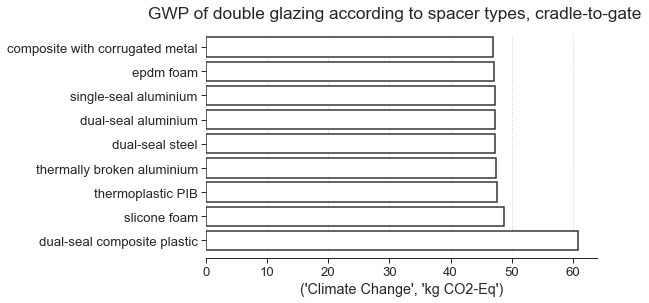

In [59]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impacts_spacers,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_spacers.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to spacer types, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [60]:
df_norm_impacts_spacers = df_impacts_spacers / df_impacts_spacers.max()
df_norm_impacts_spacers.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal           0.77              0.74    0.51   
epdm foam                                 0.77              0.76    0.52   
single-seal aluminium                     0.78              0.87    0.53   
dual-seal aluminium                       0.78              0.87    0.53   
dual-seal steel                           0.78              0.88    0.53   
thermally broken aluminium                0.78              0.87    0.54   
thermoplastic PIB                         0.78              0.78    0.54   
slicone foam                              0.80              0.80    0.57   
dual-seal composite plastic               1.00              1.00    1.00   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.83     0.89         0.83       0.87   
epdm foam                            0.83     0.89         0.85       0.87   
single-seal aluminium                0.84     0.89         0.85       0.87   
dual-seal aluminium                  0.84     0.90         0.85       0.87   
dual-seal steel                      0.84     0.90         0.85       0.87   
thermally broken aluminium           0.84     0.90         0.85       0.88   
thermoplastic PIB                    0.84     0.90         0.92       0.87   
slicone foam                         0.85     0.90         1.00       0.89   
dual-seal composite plastic          1.00     1.00         0.99       1.00   

Method                          Resources         
Unit                            megajoule points  
Name                                              
composite with corrugated metal      0.77   0.74  
epdm foam                            0.76   0.75  
single-seal aluminium                0.76   0.76  
dual-seal aluminium                  0.77   0.76  
dual-seal steel                      0.77   0.76  
thermally broken aluminium           0.77   0.76  
thermoplastic PIB                    0.77   0.77  
slicone foam                         0.80   0.79  
dual-seal composite plastic          1.00   1.00

**Comparative analysis of different infill gases:**

In [61]:
inv_gas = [act for act in bw.Database("exldb_spacers")
           if 'thermally broken aluminium' in act['name']
           ]

fu_gas = [{igu: 1} for igu in inv_gas]
fu_gas

[{'double glazing production, thermally broken aluminium, air' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, argon' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, krypton' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, xenon' (square meter, BE, ('building components/windows',)): 1}]

In [62]:
impacts_gas = []

for igu in inv_gas:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_gas.append((igu["name"], igu["location"],
                            method[1].title(), lca.score,
                            bw.methods.get(method).get('unit')))

# impacts_gas

In [63]:
df_impacts_gas = pd.DataFrame(
    impacts_gas,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_gas = pd.pivot_table(
    df_impacts_gas, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [64]:
df_impacts_gas = df_impacts_gas.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_gas = df_impacts_gas.reset_index()
df_impacts_gas['Name'] = (df_impacts_gas['Name']
                          .str.replace('double glazing production, ', '')
                          )

df_impacts_gas = df_impacts_gas.set_index('Name')

In [65]:
df_impacts_gas.round(2)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air              47.41             17.55    0.01   
thermally broken aluminium, argon            47.48             17.58    0.01   
thermally broken aluminium, krypton          52.09             19.04    0.01   
thermally broken aluminium, xenon            64.83             23.45    0.02   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.38     1.03          0.0   
thermally broken aluminium, argon        0.38     1.03          0.0   
thermally broken aluminium, krypton      0.41     1.07          0.0   
thermally broken aluminium, xenon        0.48     1.17          0.0   

Method                                         Resources          
Unit                                kg NMVOC-. megajoule  points  
Name                                                              
thermally broken aluminium, air           0.24    639.72  291.23  
thermally broken aluminium, argon         0.25    641.65  291.87  
thermally broken aluminium, krypton       0.26    714.76  308.68  
thermally broken aluminium, xenon         0.28   1046.78  398.88

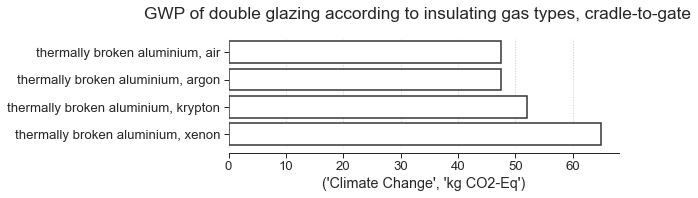

In [66]:
fig, ax = plt.subplots(figsize=(7, 2))

sns.barplot(data=df_impacts_gas,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_gas.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to insulating gas types, cradle-to-gate', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [67]:
df_norm_impacts_gas = df_impacts_gas / df_impacts_gas.max()
df_norm_impacts_gas.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air               0.73              0.75    0.24   
thermally broken aluminium, argon             0.73              0.75    0.24   
thermally broken aluminium, krypton           0.80              0.81    0.34   
thermally broken aluminium, xenon             1.00              1.00    1.00   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.81     0.88         0.85   
thermally broken aluminium, argon        0.81     0.88         0.85   
thermally broken aluminium, krypton      0.85     0.92         0.87   
thermally broken aluminium, xenon        1.00     1.00         1.00   

Method                                         Resources         
Unit                                kg NMVOC-. megajoule points  
Name                                                             
thermally broken aluminium, air           0.86      0.61   0.73  
thermally broken aluminium, argon         0.86      0.61   0.73  
thermally broken aluminium, krypton       0.91      0.68   0.77  
thermally broken aluminium, xenon         1.00      1.00   1.00

## Comparative LCA of Different Designs for IGU, Cradle-to-Gate

In [68]:
inv_igus = [act for act in bw.Database("exldb_igu")
            if 'market' in act['name']
            and ('glazing' in act['name']
            or 'vacuum' in act['name'])
            ]

fu_igus = [{igu: 1} for igu in inv_igus]

fu_igus

[{'market for triple glazing, lsg, two coatings, krypton' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, two coatings' (square meter, BE, ('building components', 'windows')): 1},
 {'market for single glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, two coatings, xenon' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, two coatings' (square meter, BE, ('building components', 'windows')): 1},
 {'market for smart glass, double glazing' (square meter, BE, ('building components', 'windows')): 1},
 {'market for single glazing, lsg' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, coated, krypto

In [69]:
impacts_igus = []

for igu in inv_igus:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_igus.append((igu["name"], igu["location"],
                             method[1].title(), lca.score,
                             bw.methods.get(method).get('unit')))

# impacts_igus

In [70]:
df_impacts_igus = pd.DataFrame(
    impacts_igus,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_igus = pd.pivot_table(
    df_impacts_igus, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [71]:
df_impacts_igus = df_impacts_igus.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_igus = df_impacts_igus.reset_index()
df_impacts_igus['Name'] = (df_impacts_igus['Name']
                           .str.replace('market for ', ''))

df_impacts_igus = df_impacts_igus.set_index('Name')

In [72]:
df_impacts_igus.round(2)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                 38.42             14.62   
single glazing, lsg, coated                         39.24             15.68   
double glazing, coated                              48.74             20.18   
double glazing, lsg                                 62.89             25.58   
double glazing, lsg, coated                         64.18             27.23   
double glazing, lsg, two coatings                   65.00             28.29   
double glazing, lsg, vacuum                         66.11             24.43   
triple glazing, coated                              66.88             28.24   
double glazing, lsg, coated, krypton                69.36             28.88   
triple glazing, lsg, two coatings                   82.34             34.22   
triple glazing, lsg, coated                         82.63             36.11   
double glazing, lsg, two coatings, xenon            84.51             34.90   
triple glazing, lsg, two coatings, krypton          92.72             37.51   
triple glazing, lsg, two coatings, xenon           121.37             47.44   
smart glass, double glazing                        701.78           1678.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.01      0.27     0.72   
single glazing, lsg, coated                   0.01      0.27     0.73   
double glazing, coated                        0.01      0.39     1.05   
double glazing, lsg                           0.01      0.46     1.23   
double glazing, lsg, coated                   0.01      0.47     1.26   
double glazing, lsg, two coatings             0.01      0.48     1.27   
double glazing, lsg, vacuum                   0.01      0.47     1.27   
triple glazing, coated                        0.01      0.53     1.43   
double glazing, lsg, coated, krypton          0.01      0.50     1.31   
triple glazing, lsg, two coatings             0.01      0.62     1.65   
triple glazing, lsg, coated                   0.01      0.62     1.65   
double glazing, lsg, two coatings, xenon      0.03      0.58     1.43   
triple glazing, lsg, two coatings, krypton    0.02      0.67     1.75   
triple glazing, lsg, two coatings, xenon      0.05      0.83     1.96   
smart glass, double glazing                   0.23      3.30     9.87   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                 0.0       0.18    645.18   
single glazing, lsg, coated                         0.0       0.18    662.13   
double glazing, coated                              0.0       0.25    659.20   
double glazing, lsg                                 0.0       0.30    983.63   
double glazing, lsg, coated                         0.0       0.31   1010.23   
double glazing, lsg, two coatings                   0.0       0.31   1027.19   
double glazing, lsg, vacuum                         0.0       0.31   1037.07   
triple glazing, coated                              0.0       0.34    905.72   
double glazing, lsg, coated, krypton                0.0       0.32   1092.32   
triple glazing, lsg, two coatings                   0.0       0.40   1261.57   
triple glazing, lsg, coated                         0.0       0.40   1261.47   
double glazing, lsg, two coatings, xenon            0.0       0.35   1482.80   
triple glazing, lsg, two coatings, krypton          0.0       

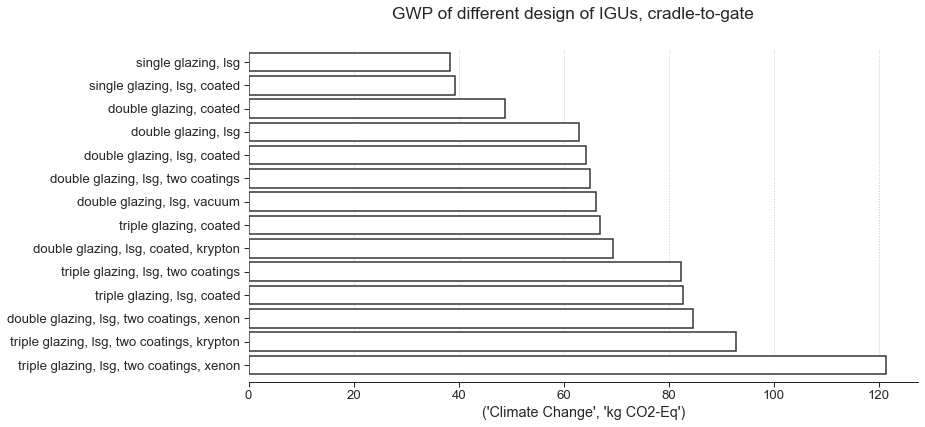

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))

df_impacts_igus_wo_smartg = df_impacts_igus.drop(
    "smart glass, double glazing", axis=0
)

sns.barplot(data=df_impacts_igus_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus_wo_smartg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [74]:
df_norm_impacts_igus_wo_smartg = (
    df_impacts_igus_wo_smartg / df_impacts_igus_wo_smartg.max()
)

df_norm_impacts_igus_wo_smartg.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.32              0.31   
single glazing, lsg, coated                          0.32              0.33   
double glazing, coated                               0.40              0.43   
double glazing, lsg                                  0.52              0.54   
double glazing, lsg, coated                          0.53              0.57   
double glazing, lsg, two coatings                    0.54              0.60   
double glazing, lsg, vacuum                          0.54              0.51   
triple glazing, coated                               0.55              0.60   
double glazing, lsg, coated, krypton                 0.57              0.61   
triple glazing, lsg, two coatings                    0.68              0.72   
triple glazing, lsg, coated                          0.68              0.76   
double glazing, lsg, two coatings, xenon             0.70              0.74   
triple glazing, lsg, two coatings, krypton           0.76              0.79   
triple glazing, lsg, two coatings, xenon             1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.11      0.32     0.36   
single glazing, lsg, coated                   0.11      0.33     0.37   
double glazing, coated                        0.11      0.47     0.53   
double glazing, lsg                           0.16      0.56     0.63   
double glazing, lsg, coated                   0.17      0.57     0.64   
double glazing, lsg, two coatings             0.18      0.58     0.65   
double glazing, lsg, vacuum                   0.17      0.57     0.65   
triple glazing, coated                        0.15      0.65     0.73   
double glazing, lsg, coated, krypton          0.22      0.60     0.67   
triple glazing, lsg, two coatings             0.22      0.75     0.84   
triple glazing, lsg, coated                   0.22      0.75     0.84   
double glazing, lsg, two coatings, xenon      0.57      0.70     0.73   
triple glazing, lsg, two coatings, krypton    0.33      0.81     0.89   
triple glazing, lsg, two coatings, xenon      1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.47       0.36      0.30   
single glazing, lsg, coated                        0.48       0.37      0.30   
double glazing, coated                             0.42       0.52      0.30   
double glazing, lsg                                0.69       0.62      0.45   
double glazing, lsg, coated                        0.70       0.63      0.46   
double glazing, lsg, two coatings                  0.70       0.64      0.47   
double glazing, lsg, vacuum                        0.71       0.64      0.48   
triple glazing, coated                             0.57       0.71      0.42   
double glazing, lsg, coated, krypton               0.71       0.66      0.50   
triple glazing, lsg, two coatings                  0.84       0.82      0.58   
triple glazing, lsg, coated                        0.86       0.82      0.58   
double glazing, lsg, two coatings, xenon           0.78       0.73      0.68   
triple glazing, lsg, two coatings, krypton         0.87       0.88      0.66   
triple glazing, lsg, two coatings, xenon           1.00       1.00      1.00   

Method                                             
U

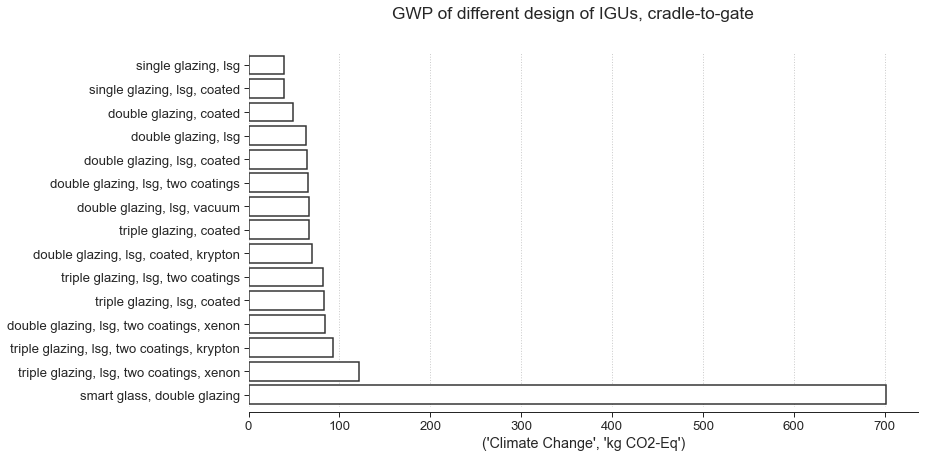

In [75]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(data=df_impacts_igus,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [76]:
df_norm_impacts_igus = df_impacts_igus / df_impacts_igus.max()
df_norm_impacts_igus.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.05              0.01   
single glazing, lsg, coated                          0.06              0.01   
double glazing, coated                               0.07              0.01   
double glazing, lsg                                  0.09              0.02   
double glazing, lsg, coated                          0.09              0.02   
double glazing, lsg, two coatings                    0.09              0.02   
double glazing, lsg, vacuum                          0.09              0.01   
triple glazing, coated                               0.10              0.02   
double glazing, lsg, coated, krypton                 0.10              0.02   
triple glazing, lsg, two coatings                    0.12              0.02   
triple glazing, lsg, coated                          0.12              0.02   
double glazing, lsg, two coatings, xenon             0.12              0.02   
triple glazing, lsg, two coatings, krypton           0.13              0.02   
triple glazing, lsg, two coatings, xenon             0.17              0.03   
smart glass, double glazing                          1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.02      0.08     0.07   
single glazing, lsg, coated                   0.02      0.08     0.07   
double glazing, coated                        0.02      0.12     0.11   
double glazing, lsg                           0.03      0.14     0.12   
double glazing, lsg, coated                   0.04      0.14     0.13   
double glazing, lsg, two coatings             0.04      0.14     0.13   
double glazing, lsg, vacuum                   0.04      0.14     0.13   
triple glazing, coated                        0.03      0.16     0.15   
double glazing, lsg, coated, krypton          0.05      0.15     0.13   
triple glazing, lsg, two coatings             0.05      0.19     0.17   
triple glazing, lsg, coated                   0.05      0.19     0.17   
double glazing, lsg, two coatings, xenon      0.12      0.18     0.15   
triple glazing, lsg, two coatings, krypton    0.07      0.20     0.18   
triple glazing, lsg, two coatings, xenon      0.21      0.25     0.20   
smart glass, double glazing                   1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.04       0.06      0.06   
single glazing, lsg, coated                        0.04       0.06      0.06   
double glazing, coated                             0.04       0.09      0.06   
double glazing, lsg                                0.06       0.11      0.09   
double glazing, lsg, coated                        0.06       0.11      0.09   
double glazing, lsg, two coatings                  0.06       0.11      0.09   
double glazing, lsg, vacuum                        0.06       0.11      0.10   
triple glazing, coated                             0.05       0.12      0.08   
double glazing, lsg, coated, krypton               0.06       0.11      0.10   
triple glazing, lsg, two coatings                  0.07       0.14      0.12   
triple glazing, lsg, coated                        0.08       0.14      0.12   
double glazing, lsg, two coatings, xenon           0.07       0.12      0.14   
triple glazing, lsg, two coatings, krypton         0.08       

# Import Results from the BEM

### Recover data saved in csv files from previous simulations:

To read directly the csv file and work from them instead of relaunching the energy simulation (Please note that this does not prevent the simulations from being run again. To do this, change the run_all boolean variable above. If the simulations are rerun, the new results will overwrite the old ones saved in the csv files):

Dataframe with all energy usage data per simulation run:

Retrieve the data from the csv. The simulation_postprocess function will merge the new results by overwriting the old ones, or simply add the new ones if they did not exist yet.

In [77]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

Dataframe with the main assumptions and results (natural gas and electricity) specific to each simulation run:

A function to recover df_step dataframes saved as csv:

In [78]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe wich replace 
    the one currently in use in the notebook.
    Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if (os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            and np.isnan(
                sum(df_step["natural_gas"]) + sum(df_step["elec_use"]))):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step updated with csv data")
    else:
        print("existing df_step kept in place")

    return df_step

## Recover the df_step dataframes:

In [79]:
df_step4 = recover_df_step(4, df_step4)

df_step updated with csv data


In [81]:
df_step4 = (
    pd.read_csv(f"outputs\steps_dir\df_step4.csv").set_index(['name'])
)

In [82]:
df_step4

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,shdg_device,thermal_curtain,sg,sg_coated,dg,...,dg_coated_krypton,dg_2coatings,tg_coated,tg_2coatings,tg_2coatings_krypton,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,,,,,,,,,,,
d_a_2126_dg_init_vav_sd,dg_init_bronze,_Heating_21,_Cooling_26,336.991453,570.074092,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
d_b_2126_dg0_vav_sd,dg_0_clear,_Heating_21,_Cooling_26,337.410256,591.294926,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
d_c_2126_sg1_vav_sd,sg_1_clear,_Heating_21,_Cooling_26,610.038462,581.988626,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
d_d_2126_sg2_vav_sd,sg_2_coated,_Heating_21,_Cooling_26,376.551282,561.245038,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
d_e_2126_dg1_vav_sd,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,244.696581,621.582249,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_f_2126_dg2_vav_sd,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,243.739316,594.121600,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_g_2126_dg3_vav_sd,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,241.303419,597.283059,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_h_2126_dg4_vav_sd,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,237.252137,571.203100,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_i_2126_dg5_vav_sd,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,239.410256,581.298874,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analysis of the Whole Life Cycle of Curtain Walls

## Setup of the LCA

First, we define the activity of dismantling, and thus disposal, of the existing curtain wall:

In [ ]:
out_old_cw = exldb_cw.get('dismantling_cw_old_dg')
# Check:
print('My activity is:\n', out_old_cw)

Then we define the production activity of the new curtain wall:

In [ ]:
prod_cw = exldb_cw.get('production_cw')
# Check:
print('My activity is:\n', prod_cw)

We define the use phase activity (not linked to production):

In [ ]:
use_bldg_w_cw = exldb_cw.get('use_glazed_office_bldg')
# Check:
print('My activity is:\n', use_bldg_w_cw)

We define a use phase activity integrating the production phase:

In [ ]:
prod_and_use_cw = exldb_cw.get('use_cw')
# Check:
print('My activity is:\n', prod_and_use_cw)

We define a maintenance activity:

In [ ]:
repair_cw = exldb_cw.get('maintenance_cw')
# Check:
print('My activity is:\n', repair_cw)

And finally, the end-of-life activity:

In [ ]:
eol_cw = exldb_cw.get('eol_cw')
# Check:
print('My activity is:\n', eol_cw)

List of parameters:

In [ ]:
print("Project parameters:")
for p in ProjectParameter.select():
    print(p.name, ":", p.amount)

print("------")
print("Database parameters:")
for p in DatabaseParameter.select():
    print(p.name, ":", p.amount)

print("------")
print("Activity parameters:")
for p in ActivityParameter.select():
    if "dummy" not in p.name:
        print(p.name, ":", p.amount)

In [ ]:
# Define the details of the parameter:
activity_data = [{'name': 'param_natural_gas', 'amount': 0.0,
                  'database': 'exldb_cw', 'code': 'par_natgas'},
                 {'name': 'param_elec_use', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_elec'},
                 {'name': 'param_lifespan', 'amount': 40.0,
                     'database': 'exldb_cw', 'code': 'par_lifespan'},
                 {'name': 'param_shdg_device', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_shdg'},
                 {'name': 'param_thermal_curtain', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_curtain'},
                 {'name': 'param_sg', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw1'},
                 {'name': 'param_sg_coated', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw2'},
                 {'name': 'param_dg', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw3'},
                 {'name': 'param_dg_coated', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw4'},
                 {'name': 'param_dg_coated_krypton', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw5'},
                 {'name': 'param_dg_2coatings', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw6'},
                 {'name': 'param_tg_coated', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw7'},
                 {'name': 'param_tg_2coatings', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw8'},
                 {'name': 'param_tg_2coatings_krypton', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw9'},
                 {'name': 'param_tg_2coatings_xenon', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw10'},
                 {'name': 'param_ccf', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw11'},
                 {'name': 'param_dg_vacuum', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw12'},
                 {'name': 'param_dg_smart', 'amount': 0.0,
                  'database': 'exldb_cw', 'code': 'par_cw13'},
                 {'name': 'param_dsf', 'amount': 0.0,
                     'database': 'exldb_cw', 'code': 'par_cw14'}]

parameters.new_activity_parameters(
    activity_data, "cw_param_group", overwrite=True)
parameters.add_exchanges_to_group("cw_param_group", prod_cw)
parameters.add_exchanges_to_group("cw_param_group", use_cw)
ActivityParameter.recalculate_exchanges("cw_param_group")

# Create a list with parameter names:
p_name_ls = []
for p in ActivityParameter.select():
    if "dummy" not in p.name:
        p_name_ls.append(p.name)
        print(p, p.amount)

## Functions to Perform the LCAs

Write a function to perform the LCA according to activities and parameter sets:

In [ ]:
def lca_cw_gwp(df_step, act):
    """
    Perform a simple lca for different scenarios 
    according to parameters defined in df_step

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess

    Returns
    -------
    ls_results: list of values for IPCC GWP
    """

    # To save results:
    ls_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        parameters.add_exchanges_to_group("cw_param_group", act)
        ActivityParameter.recalculate_exchanges("cw_param_group")

        lca = LCA({act: 1}, method_ilcd_gwp)
        lca.lci()
        lca.lcia()
        ls_results.append({'run': name_scenario, 'result': lca.score})

    return ls_results

Write a function to perform a multi_method LCA, with small_methods, according to activities and parameter sets:

In [ ]:
# Reminder of the reduced list of methods:
methods_small

In [ ]:
def lca_cw_mlca_small(df_step, act):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess

    Returns
    -------
    ls_mlca_small_results: list of values
    """

    # To save results:
    ls_mlca_small_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        parameters.add_exchanges_to_group("cw_param_group", act)
        ActivityParameter.recalculate_exchanges("cw_param_group")

        lca = LCA({act: 1}, method_ilcd_gwp)
        lca.lci()

        for method in methods_small:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_small_results.append((name_scenario,
                                          method[1].title(), lca.score,
                                          bw.methods.get(method).get('unit')))

    return ls_mlca_small_results

Write a function to perform a multi_method LCA, with full_methods, according to activities and parameter sets:

In [ ]:
# Reminder of the full list of methods:
methods_full

In [ ]:
def lca_cw_mlca_full(df_step, act):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess

    Returns
    -------
    ls_mlca_full_results: list of values
    """

    # To save results:
    ls_mlca_full_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        parameters.add_exchanges_to_group("cw_param_group", act)
        ActivityParameter.recalculate_exchanges("cw_param_group")

        lca = LCA({act: 1}, method_ilcd_gwp)
        lca.lci()

        for method in methods_full:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_full_results.append((name_scenario,
                                         method[1].title(), lca.score,
                                         bw.methods.get(method).get('unit')))

    return ls_mlca_full_results

A little function to transform the a list of mlca_results in a DataFrame:

In [ ]:
def ls_to_df_mlca(ls):
    """
    A little function to transform the ls_mlca_results 
    in a readable DataFrame

    Parameters
    ----------
    ls: the list

    Returns
    -------
    df: the DataFrame
    """
    # DataFrame to then work w/ results:
    df = pd.DataFrame(ls, columns=["Name", "Method",
                                   "Score", "Unit"]
                      )

    df = pd.pivot_table(df, index=["Name"],
                        columns=["Method", "Unit"],
                        values="Score"
                        )

    return df

A function to save mlca_full_results in a DataFrame, for each simulation run and LCA phase:

In [ ]:
# Initialise a DataFrame:
df_mlca_full_raw_results = pd.DataFrame()

In [ ]:
def ls_to_df_mlca_full(step, ls, act, df_results):
    """
    A function to append a list of mlca results in a DataFrame, 
        with values organised per simulation run (index), 
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    ls: the list of results.
    df_results: a DataFrame where LCA results will be saved.
    act: activity for which the LCA has been done.

    Returns
    -------
    df_results
    """

    # New DataFrame from list of results:
    df_temp = pd.DataFrame(ls, columns=["Name", "Method", "Score", "Unit"])
    # Add information regarding the step:
    df_temp["Step"] = step
    # Add information regarding the LCA phase:
    df_temp["LCA Phase"] = str(act["name"])
    # Pivot the DataFrame:
    df_temp = pd.pivot_table(df_temp, index=["Step", "Name"],
                             columns=["LCA Phase", "Method", "Unit"],
                             values="Score"
                             )
    if df_results.empty:
        df_results = df_temp
    else:
        df_results.columns.difference(df_temp.columns)
        # Merge:
        df_results = pd.merge(df_temp, df_results, on=("Step", "Name"))

    return df_results

A function to conduct a mLCA per activity and save the mlca_full_results in a DataFrame, for each simulation run and each LCA phase:

In [ ]:
def full_lca_to_df(step, df_step, df_results):
    """
    A function to append a list of mlca results in a DataFrame,
        with values organised per simulation run (index),
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    df_step: DataFrame with list of parameters and their values

    Returns
    -------
    df_results: a DataFrame where LCA results are saved,
        simulation run as index, LCA phase and impact indicators as columns.
    """

    for act in [out_old_cw, prod_cw, use_bldg_w_cw, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step, act)
        df_results = ls_to_df_mlca_full(
            step, ls, act, df_results)

    return df_results

## Step 4: Analysis of Different Glazing Types

In [ ]:
# Overview of the dataframe with parameters for step_4::
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step4)

GWP only:

In [ ]:
step4_prod_gwp_results = lca_cw_gwp(df_step4, prod_cw)

In [ ]:
step4_prod_gwp_results

Multi-Method LCA, ILCD, methods_small:

In [ ]:
# Multi-method LCA:
step4_prod_mlca_results = lca_cw_mlca_small(df_step4, prod_cw)
# Convert results to df:
df_step4_prod_mlca_results = ls_to_df_mlca(step4_prod_mlca_results)

In [ ]:
df_step4_prod_mlca_results

Full life cycle assessment, ILCD methods:

In [ ]:
df_mlca_full_raw_results = full_lca_to_df("step_4", df_step4,
                                          df_mlca_full_raw_results)

In [ ]:
df_mlca_full_raw_results.loc["step_4"].xs('Climate Change', axis=1,
                                          level=1, drop_level=False)

### Use Phase

GWP only:

In [ ]:
step1_use_gwp_results = lca_cw_gwp(df_step1, use_cw)

In [ ]:
step1_use_gwp_results

Multi-Method LCA, ReCiPe (GWP100, ODPinf, PMFP, POFP):

In [ ]:
# Multi-method LCA:
step1_use_mlca_results = lca_cw_mlca_small(df_step1, use_cw)

# Convert results to df:
df_step1_use_mlca_results = ls_to_df_mlca(step1_use_mlca_results)

In [ ]:
df_step1_use_mlca_results.round(2)

### Post-processing

In [ ]:
lifespan = [p.amount for p in DatabaseParameter.select()
            if p.name == 'lifespan'][0]

In [ ]:
df_step1_gwp = pd.DataFrame(
    {'Year': np.arange(lifespan+2), 'Step': 'ref', 'Scenario': 'no_retrofit', 'GWP100': 0})

df_step1_gwp = df_step1_gwp.pivot(
    index='Year', columns=['Step', 'Scenario'], values='GWP100')

In [ ]:
for y in np.arange(lifespan):
    df_step1_gwp[('ref', 'no_retrofit')][y+2] = (
        df_step1_gwp[('ref', 'no_retrofit')][y+1]
        + [val['result'] for val in step1_use_gwp_results
           if val["run"] == "1_1926_dg_init"][0] / lifespan)

# df_step1_gwp

In [ ]:
gwp_per_year_init = df_step1_gwp[('ref', 'no_retrofit')][2]

for scenario in df_step1.index:
    df_step1_gwp[('1', scenario)] = 0

    gwp_per_year = ([val['result'] for val in step1_use_gwp_results
                    if val["run"] == scenario][0] / lifespan)

    # GWP at year 1 = production:
    df_step1_gwp.loc[df_step1_gwp.index == 1, ('1', scenario)] = (
        [val['result'] for val in step1_prod_gwp_results
         if val["run"] == scenario][0]
    )

    # positive or negative gwp as consequential of retrofit:
    for y in np.arange(lifespan):
        df_step1_gwp.loc[df_step1_gwp.index == y+2, ('1', scenario)] = (
            df_step1_gwp[('1', scenario)][y+1]
            + gwp_per_year - gwp_per_year_init)

In [ ]:
# Plot the evolution of the GWP per year:
fig, ax = plt.subplots(figsize=(16, 9))

for glazing in df_step1.index:
    if 'dg' in glazing:
        if 'dg_init' in glazing:
            sns.lineplot(data=df_step1_gwp.reset_index(),
                         x='Year', y=('1', '1_1926_dg_init'),
                         color='firebrick',
                         ax=ax)

        else:
            sns.lineplot(data=df_step1_gwp.reset_index(),
                         x='Year', y=('1', glazing),
                         color='steelblue',
                         ax=ax)
    if 'tg' in glazing:
        sns.lineplot(data=df_step1_gwp.reset_index(),
                     x='Year', y=('1', glazing),
                     color='forestgreen',
                     ax=ax)

ax.fill_between(np.array(df_step1_gwp.index),
                np.array(df_step1_gwp['1', '1_1926_dg3']),
                np.array(df_step1_gwp['1', '1_1926_dg6']), alpha=0.25)

ax.axhline(y=0, c='black', linestyle=':', linewidth=0.75)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.yaxis.label.set_visible(False)
ax.set_xlim(0, 45)
ax.set_ylim(-500, 1000)

fig.suptitle('')
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot the evolution of the GWP per year:
fig, ax = plt.subplots(figsize=(16, 9))

for glazing in df_step1.index:
    if 'dg_init' in glazing:
        sns.lineplot(data=df_step1_gwp.reset_index(),
                     x='Year', y=('1', '1_1926_dg_init'),
                     color='firebrick',
                     ax=ax)

    if 'tg' in glazing:
        sns.lineplot(data=df_step1_gwp.reset_index(),
                     x='Year', y=('1', glazing),
                     color='forestgreen',
                     ax=ax)

ax.fill_between(np.array(df_step1_gwp.index),
                np.array(df_step1_gwp['1', '1_1926_dg3']),
                np.array(df_step1_gwp['1', '1_1926_dg6']), alpha=0.10)

ax.axhline(y=0, c='black', linestyle=':', linewidth=0.75)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.yaxis.label.set_visible(False)
ax.set_xlim(0, 45)
ax.set_ylim(-500, 1000)

fig.suptitle('')
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot the evolution of the GWP per year:
fig, ax = plt.subplots(figsize=(16, 9))

for glazing in df_step1.index:
    if 'dg_init' in glazing:
        sns.lineplot(data=df_step1_gwp.reset_index(),
                     x='Year', y=('1', '1_1926_dg_init'),
                     color='firebrick',
                     ax=ax)

    if 'sg' in glazing:
        sns.lineplot(data=df_step1_gwp.reset_index(),
                     x='Year', y=('1', glazing),
                     color='darkorange',
                     ax=ax)

ax.fill_between(np.array(df_step1_gwp.index),
                np.array(df_step1_gwp['1', '1_1926_dg3']),
                np.array(df_step1_gwp['1', '1_1926_dg6']), alpha=0.10)

ax.axhline(y=0, c='black', linestyle=':', linewidth=0.75)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.yaxis.label.set_visible(False)
ax.set_xlim(0, 45)
ax.set_ylim(-500, 1000)

fig.suptitle('')
sns.despine(offset=5)
plt.show()

# Energy Mix: Sensitivity Analysis

In [ ]:
# List of activities to change, in this case electricity markets:
locations = ["FR", "DE", "PL", "NL", "CH"]

act_name = "market for electricity, low voltage"

el_markets = [('ecoinvent 3.7 cut-off', act['code'])
              for act in eicutdb.search(act_name, limit=200)
              for location in locations
              if act_name in act['name'] and location in act['location']
              and "US-FRCC" not in act['location']
              and "US-SERC" not in act['location']]

# Remove "market for electricity, low voltage, label-certified" for CH:
el_markets.pop(5)

el_markets

In [ ]:
act_cw = exldb_cw.get('use_cw')

# Printing the exchanges
print('My activity is:\n', act_cw,
      '\n-------\nAnd its exchanges:\n-------')

for i in list(act_cw.exchanges()):
    print(i['type'])
    print(i)
    print(i['input'])
    print('-------')

In [ ]:
exc = list(act_cw.exchanges())[10]
exc

In [ ]:
# Make a copy of the activity, substitute the background process
# save and calculate:

cw_elec_results = []

for m in el_markets[0:2]:
    act_cw_copy = act_cw.copy()
    exc['input'] = m
    exc.save()
    lca = LCA({act_cw_copy: 1}, ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    cw_elec_results.append(lca.score)

In [ ]:
# Results for Belgium:
lca = LCA({act_cw: 1}, method_ilcd_gwp)
lca.lci()
lca.lcia()
be_cw_elec_result = lca.score

In [ ]:
be_cw_elec_result

In [ ]:
np.mean([(i/be_cw_elec_result) for i in cw_elec_results])

In [ ]:
pd.DataFrame(cw_elec_results).describe()

In [ ]:
plt.boxplot(cw_elec_results)
plt.ylabel(methods[('IPCC 2013', 'climate change', 'GWP 100a')]['unit'])
plt.xlabel('El Production')